In [1]:
from collections import deque, namedtuple
import random
import numpy as np

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:

    def __init__(self, capacity=50_000):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward, done):
        """Save a transition."""
        self.memory.append(Transition(state, action, next_state, reward, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(DQN, self).__init__()
        # state_shape = (80, 160, 4)
        height, width, channel = state_shape
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4, padding=2), nn.ReLU(),      # 20×40
            nn.Conv2d(32, 64, 4, 2, padding=1), nn.ReLU(),     # 9×19
            nn.Conv2d(64, 64, 3, 1, padding=1), nn.ReLU(),     # 7×17
            nn.Flatten(),
            nn.Linear(64*10*20, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.net(x)
    

In [ ]:
class Agent:

    def __init__(self, state_shape, n_actions, gamma=0.99, capacity=10_000, batch_size=32, target_update=1000, pth_path=None):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # Mac OS
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = ReplayMemory(capacity)
        self.model = DQN(state_shape, n_actions).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

        if pth_path is not None:
            self.model.load_state_dict(torch.load(pth_path, map_location=self.device))
            print('load model from', pth_path)

        self.target_net = DQN(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.model.state_dict())
        self.target_update = target_update
        self.learn_step_counter = 0
        self.loss_item = None

    def _replay(self):
        if len(self.memory) < self.batch_size:
            return
        # list of transition
        batch = self.memory.sample(self.batch_size)
        # Transition, column: len(tuple) == batch_size
        batch = Transition(*zip(*batch))
        # batch to tensor
        # batch = torch.cat([torch.as_tensor(t, device=self.device).unsqueeze(0) for t in batch]).float()
        batch = [torch.as_tensor(t, device=self.device).float() for t in batch]
        state, action, next_state, reward, done = batch
        action = action.unsqueeze(1)
        # 把action改成int64
        action = action.to(torch.int64)
        reward = reward.unsqueeze(1)
        done = done.unsqueeze(1)
        # print(f'state: {state.shape}, action: {action.shape}, next_state: {next_state.shape}, reward: {reward.shape}, done: {done.shape}')

        #state shape: (batch_size, 4, 80, 160)
        #action shape: (batch_size, 1)
        #next_state shape: (batch_size, 4, 80, 160)
        #reward shape: (batch_size, 1)
        #done shape: (batch_size, 1)
        self.model.eval()
        # pred
        state_action_values = self.model(state).gather(dim=1, index=action) # self.model 输出是 [batch, action_space]，gather(dim=1, index=action) 取出 action 对应的 Q 值
        next_state_values = self.target_net(next_state).max(dim=1)[0].detach().unsqueeze(1)
        expected_state_action_values = (next_state_values * self.gamma * (1 - done)) + reward

         # 定期更新目标网络
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update == 0:
            self.target_net.load_state_dict(self.model.state_dict())

        # loss
        self.model.train()
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

        # optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.loss_item = loss.item()

    def update_q_function(self):
        self._replay()

    def memorize(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)

    def choose_action(self, state, episode):
        eps = 0.5 * 1 / (1+episode)
        if random.random() < eps:
            # explore
            action = random.randrange(self.n_actions) # shape: (1,)
            action = torch.tensor([action]).unsqueeze(0) # shape: (1,1)
        else:
            # exploit
            state = torch.as_tensor(state, device=self.device).unsqueeze(0).float() # shape: (1, 4, 80, 160)
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).argmax() # shape: (1,)
                action = action.view(1, 1) # shape: (1,1)
        return action

        

### agent 与 env 交互

In [ ]:
import gym
import gym_chrome_dino
from gym_chrome_dino.utils.wrappers import make_dino
# env = gym.make('ChromeDino-v0')
env = gym.make('ChromeDinoNoBrowser-v0')
env = make_dino(env, timer=False, frame_stack=True)
n_actions = env.action_space.n
state_shape = env.observation_space.shape

score_history = []
loss_history = []
max_episode = 10_000
# agent = Agent(state_shape, n_actions, capacity=10_000, batch_size=64, pth_path='./dino_dqn_122.pth')
agent = Agent(state_shape, n_actions, capacity=10_000, batch_size=64)


episode = 0
for episode in range(max_episode):
    state = env.reset()
    state = np.array(state._frames)[:, :, :, 0] # shape: (4, 80, 160)
    done = False
    while not done:
        action = agent.choose_action(state, episode)

        next_state, reward, done, info = env.step(action.item())
        next_state = np.array(next_state._frames)[:, :, :, 0] # shape: (4, 80, 160)

        reward = torch.tensor([reward], device=agent.device).float()
        done = torch.tensor([done], device=agent.device).float()
        
        agent.memorize(state, action, next_state, reward, done)
        agent.update_q_function()
        state = next_state
    
    score_history.append(env.unwrapped.game.get_score())
    loss_history.append(agent.loss_item)
    if episode % 10 == 0:
        eps = 0.5 * 1 / (1+episode)
        print(f"episode: {episode}, max score from 10 games: {max(score_history[-10:])}, eps: {eps:.3f}")
    
        

load model from ./dino_dqn_122.pth


/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_4788/1010788039.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  batch = [torch.as_tensor(t, device=self.device).float() for t in batch]


episode: 0, score: 56, eps: 0.500
episode: 1, score: 41, eps: 0.250
episode: 2, score: 42, eps: 0.167
episode: 3, score: 42, eps: 0.125
episode: 4, score: 41, eps: 0.100
episode: 5, score: 42, eps: 0.083
episode: 6, score: 56, eps: 0.071
episode: 7, score: 41, eps: 0.062
episode: 8, score: 41, eps: 0.056
episode: 9, score: 41, eps: 0.050
episode: 10, score: 41, eps: 0.045
episode: 11, score: 41, eps: 0.042
episode: 12, score: 42, eps: 0.038
episode: 13, score: 41, eps: 0.036
episode: 14, score: 42, eps: 0.033
episode: 15, score: 41, eps: 0.031
episode: 16, score: 41, eps: 0.029


KeyboardInterrupt: 

In [ ]:
# 保存模型权重
torch.save(agent.model.state_dict(),f'./dino_dqn_{episode}.pth')
print(f'saved model to ./dino_dqn_{episode}.pth')

# 载入模型权重
# agent.model.load_state_dict(torch.load(f'./dino_dqn_{episode}.pth'))

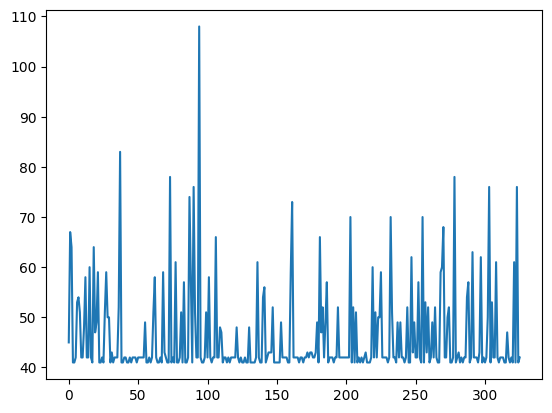

In [ ]:
import matplotlib.pyplot as plt
plt.plot(score_history)
plt.xlabel('episode')
plt.ylabel('score')
plt.title('score history')
plt.show()

In [ ]:
plt.plot(loss_history)
plt.xlabel('episode')
plt.ylabel('loss')
plt.title('loss history')
plt.show()